In [1]:
from Parameters import ModelParams
from Mass_Loss_Class import MassLoss
from Fractionation_Class import Fractionation
from Model_Data_Loader import ModelDataLoader
from Results_Handler import ResultsHandler

Excluded: RS_flow (3.46e+07) < REUV (4.88e+08) for planet mass=0.25 M_earth, radius=0.73 R_earth.
Excluded: RS_flow (6.92e+07) < REUV (5.70e+08) for planet mass=0.50 M_earth, radius=0.87 R_earth.
Excluded: RS_flow (1.38e+08) < REUV (6.77e+08) for planet mass=1.00 M_earth, radius=1.04 R_earth.
Excluded: RS_flow (2.77e+08) < REUV (8.10e+08) for planet mass=2.00 M_earth, radius=1.25 R_earth.
Excluded: RS_flow (4.15e+08) < REUV (8.98e+08) for planet mass=3.00 M_earth, radius=1.40 R_earth.
Excluded: RS_flow (5.54e+08) < REUV (9.65e+08) for planet mass=4.00 M_earth, radius=1.50 R_earth.
Excluded: RS_flow (6.92e+08) < REUV (1.02e+09) for planet mass=5.00 M_earth, radius=1.59 R_earth.
Excluded: RS_flow (8.31e+08) < REUV (1.06e+09) for planet mass=6.00 M_earth, radius=1.66 R_earth.


/Users/mvalatsou/PhD/Repos/Mass-Loss/Mass_Loss_Class.py:96: RuntimeWarning: divide by zero encountered in scalar divide
  diff = (rho_EUV * cs_eq**2 - rho_flow * (u_launch**2 + cs_use**2)) / (2. * rho_EUV * cs_eq**2)
/Users/mvalatsou/PhD/Repos/Mass-Loss/Mass_Loss_Class.py:149: RuntimeWarning: divide by zero encountered in scalar divide
  diff = (rho_EUV * cs_eq**2 - rho_flow * (u_RL**2 + cs_RL**2)) / (2. * rho_EUV * cs_eq**2)
/Users/mvalatsou/PhD/Repos/Mass-Loss/Mass_Loss_Class.py:96: RuntimeWarning: overflow encountered in scalar divide
  diff = (rho_EUV * cs_eq**2 - rho_flow * (u_launch**2 + cs_use**2)) / (2. * rho_EUV * cs_eq**2)
/Users/mvalatsou/PhD/Repos/Mass-Loss/Mass_Loss_Class.py:149: RuntimeWarning: overflow encountered in scalar divide
  diff = (rho_EUV * cs_eq**2 - rho_flow * (u_RL**2 + cs_RL**2)) / (2. * rho_EUV * cs_eq**2)


Excluded: RS_flow (9.69e+08) < REUV (1.10e+09) for planet mass=7.00 M_earth, radius=1.72 R_earth.
Excluded: RS_flow (1.11e+09) < REUV (1.14e+09) for planet mass=8.00 M_earth, radius=1.78 R_earth.
Mass-loss results: [{'REUV': 1171068905.3113635, 'RS_flow': np.float64(1246154475.2274172), 'cs': 1200000.0, 'Mdot': np.float64(678443318752.1595)}, {'REUV': 1199501271.834524, 'RS_flow': np.float64(1384551215.4203272), 'cs': 1200000.0, 'Mdot': np.float64(669166015493.2133)}, {'REUV': 1225096320.9156144, 'RS_flow': np.float64(1522958538.3315601), 'cs': 1200000.0, 'Mdot': np.float64(655341300597.6946)}, {'REUV': 1248982411.6959996, 'RS_flow': np.float64(1661401778.5381563), 'cs': 1200000.0, 'Mdot': np.float64(638697758041.3275)}, {'REUV': 1271218593.8923018, 'RS_flow': np.float64(1799825062.5702794), 'cs': 1200000.0, 'Mdot': np.float64(619652927991.9897)}, {'REUV': 1292735587.9470193, 'RS_flow': np.float64(1938414227.6413832), 'cs': 1200000.0, 'Mdot': np.float64(599541946641.374)}, {'REUV': 131

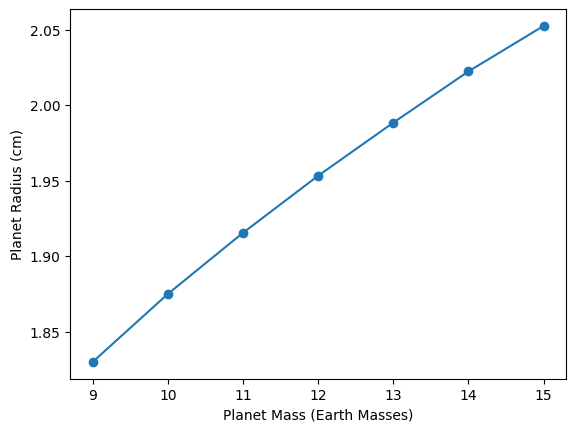

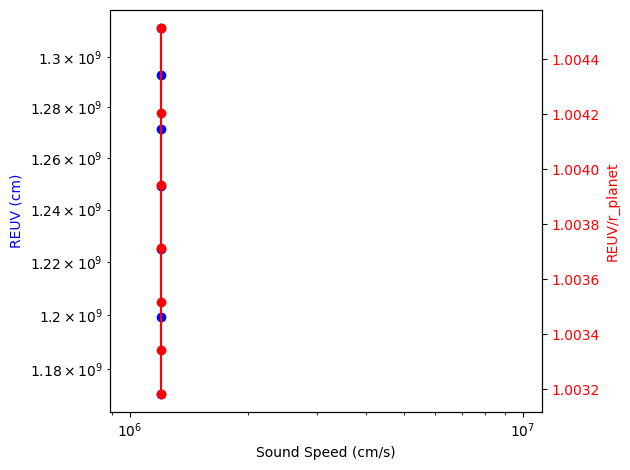

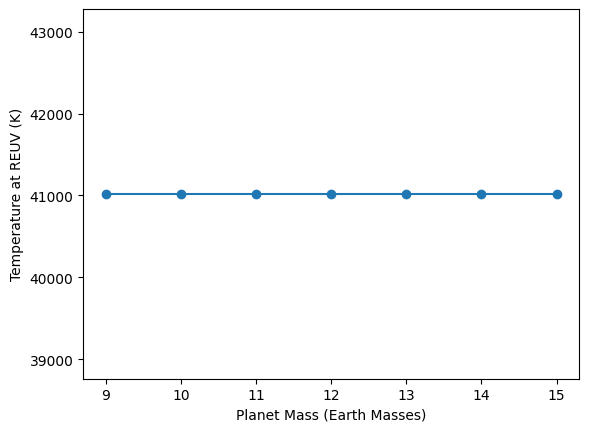

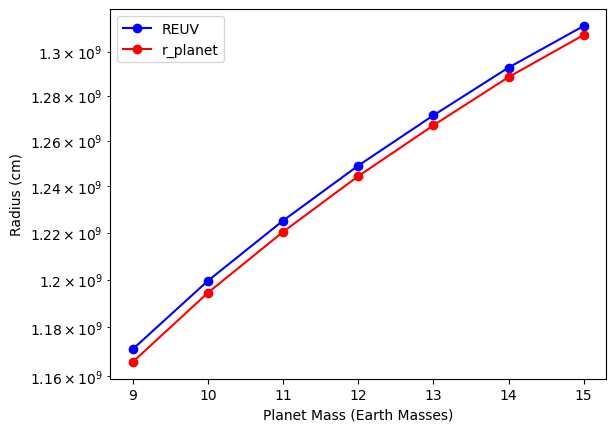

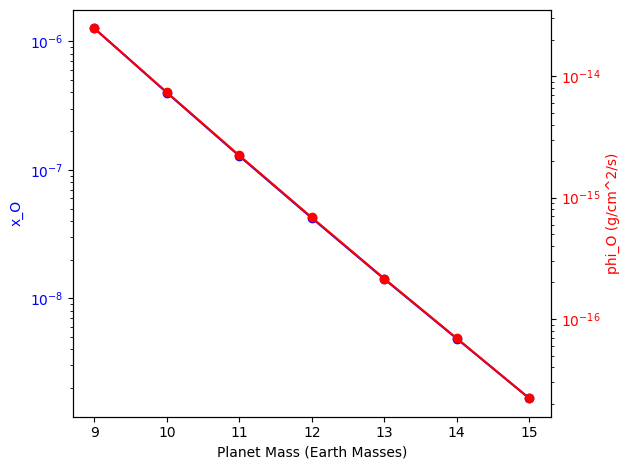

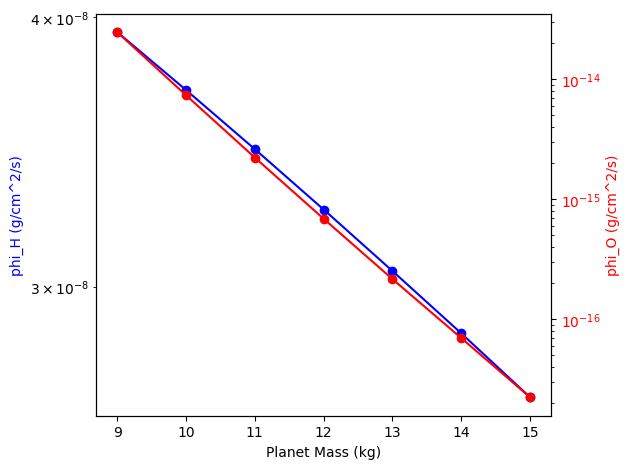

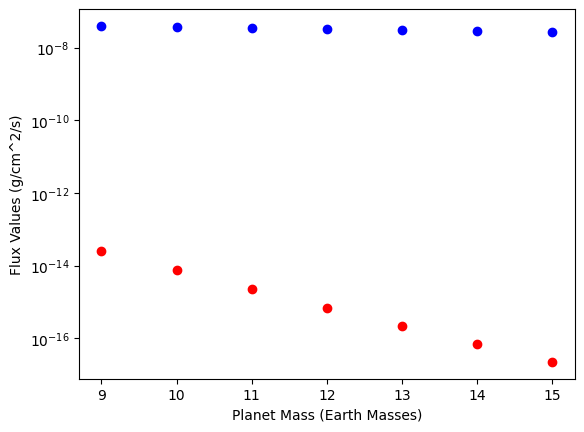

In [2]:
def main():

    # initialize parameters and classes
    params = ModelParams()
    base_path = '/Users/mvalatsou/PhD/Repos/MR_perplex/OUTPUT/CW/critical_WMF/gridmin295/'
    data_loader = ModelDataLoader(base_path)
    mass_loss = MassLoss(params)
    fractionation = Fractionation(params)

    # load data
    m_planet = [0.25, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    water_percent = [x / 10 for x in range(1, 81)]
    radii_list, mass_list, teq_list = data_loader.load_model_data(m_planet, water_percent)

    # mass loss model
    results = mass_loss.compute_mass_loss_parameters(mass_list, radii_list, teq_list)
    relevant_results = [{'REUV': res['REUV'], 'RS_flow': res['RS_flow'], 'cs': res['cs'], 'Mdot': res['Mdot']} for res in results]
    print("Mass-loss results:", relevant_results)

    # fractionation model
    all_results = []
    for planet_index, result in enumerate(results):
        cs = result['cs']
        REUV = result['REUV']
        Mdot = result['Mdot']
        m_planet = result['mass']
        r_planet = result['radius']
        Teq = result['Teq']

        T_REUV, b_i, mass_difference, flux_total, reservoir_ratio = fractionation.preprocess_fractionation_params(cs, REUV, Mdot, Teq)

        phi_O, phi_H, x_O = fractionation.iterative_fractionation(flux_total, REUV, m_planet, T_REUV, b_i, mass_difference, reservoir_ratio)
        print(f"Planet {planet_index} Fractionation Results: phi_O = {phi_O}, phi_H = {phi_H}, x_O = {x_O}")

        planet_results = {'m_planet': m_planet, 'r_planet': r_planet, 'REUV': REUV, 'cs': cs, 'Mdot': Mdot, 'T_REUV': T_REUV, 'phi_H': phi_H, 'phi_O': phi_O, 'x_O': x_O, 'REUV': REUV, 'cs': cs, 'Mdot': Mdot}
        all_results.append(planet_results)

    # save and/or plot results
    # ResultsHandler.save_results(all_results, "fractionation_results.pkl")
    ResultsHandler.plot_m_planet_r_planet(all_results)
    ResultsHandler.plot_cs_REUV(all_results)
    ResultsHandler.plot_T_REUV_m_planet(all_results)
    ResultsHandler.plot_REUV_r_planet_vs_m_planet(all_results)
    ResultsHandler.plot_xO_phiO_vs_m_planet(all_results)
    ResultsHandler.plot_phiH_phiO_vs_m_planet(all_results)
    ResultsHandler.plot_phiH_phiO_vs_m_planet_color(all_results)

if __name__ == "__main__":
   main()